## Part 2. Model Training & Evaluation - RNN   
Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from
Part 0, you need to train a deep learning model for sentiment classification using the training set,
conforming to these requirements:


• Use the pretrained word embeddings from Part 1 as inputs; do not update them during training
(they are “frozen”).   

• Design a simple recurrent neural network (RNN), taking the input word embeddings, and
predicting a sentiment label for each sentence. To do that, you need to consider how to
aggregate the word representations to represent a sentence.   

• Use the validation set to gauge the performance of the model for each epoch during training.
You are required to use accuracy as the performance metric during validation and evaluation. 
   
• Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g.,
SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and
mini-batch size. (You should use the validation set to determine the optimal configuration.)
Train the model until the accuracy score on the validation set is not increasing for a few
epochs.
   
• Evaluate your trained model on the test dataset, observing the accuracy score.

In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from datasets import load_dataset

In [3]:
# We omit warnings to keep the output clean
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
from common_utils import load_glove_embeddings, set_seed
import nltk

In [5]:
# set seed 
set_seed()

In [6]:
# initialize parameters
BATCH_SIZE = 32
INPUT_SIZE = 100 # word embedding size 
HIDDEN_SIZE = 128 # just as a starter to see 
NUM_EPOCHS = 100 

In [7]:
EMBEDDING_DIM=100

In [8]:
# initialize word embeddings
word_embeddings = load_glove_embeddings()

Loading GloVe embeddings...


Repo card metadata block was not found. Setting CardData to empty.


Total GloVe words loaded: 400000


In [41]:
class vanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super().__init__()
    self.num_layers = num_layers 
    self.hidden_size = hidden_size 
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
    self.fc = nn.Linear(hidden_size, num_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    output, h_t = self.rnn(x, h0) # we can just use the last hidden state output as the 
    last_hidden = h_t[-1]
    logits = self.sigmoid(self.fc(last_hidden))
    return logits 

In [10]:
# load dataset from huggingface first 
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [9]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})

In [11]:
with open('result/word2idx.json', "r") as file:
    word2idx = json.load(file)

In [ ]:
# create train, validate and test datasets and dataloaders 
from torch.utils.data import Dataset, DataLoader 

# TODO: change the num_tokens 
class EmbeddingsDataset(Dataset):
  def __init__(self, X, y, num_tokens_per_sentence=12, word_embeddings=word_embeddings):
    self.num_tokens_per_sentence = 8
    self.word_embeddings = word_embeddings
    self.X = X # train_dataset['text']
    self.y = y # train_dataset['label']
    self.len = len(self.X)
    
  def __getitem__(self, index):
    # tokenize the sentence 
    tokens = self.tokenize_sentence(self.X[index])
    # convert each token to embeddings 
    sentence_tensor = self.convert_sentence_into_embedding_tensor(tokens)
    label = torch.tensor(self.y[index], dtype=torch.float)
    return sentence_tensor, label 

  def __len__(self):
    return self.len 

  def tokenize_sentence(self, x): 
    '''
    returns a list containing the embeddings of each token 
    '''
    tokens = nltk.word_tokenize(x)
    return tokens 

  def convert_sentence_into_embedding_tensor(self, tokens):
    sentence_embeddings = [] 
    num_tokens_used = 0
    for i, token in enumerate(tokens): 
      if num_tokens_used == self.num_tokens_per_sentence:
        break # we have enough of tokens from the sentence 

      if token in self.word_embeddings: # only use words that are in the word_embeddings matrix, otherwise skip
        embedding_tensor = torch.tensor(self.word_embeddings[token], dtype=torch.float)
        sentence_embeddings.append(embedding_tensor)
      num_tokens_used += 1 

    # if not enough tokens in the sentence, pad with zero tensors 
    if len(sentence_embeddings) < self.num_tokens_per_sentence:
            # Padding with zero vectors if less than 8 embeddings
            padding = [torch.zeros(EMBEDDING_DIM) for _ in range(self.num_tokens_per_sentence - len(sentence_embeddings))]
            sentence_embeddings.extend(padding)

    sentence_tensor = torch.stack(sentence_embeddings)
    return sentence_tensor 
  



In [79]:
train_dataset_ed = EmbeddingsDataset(train_dataset['text'], train_dataset['label'])
validation_dataset_ed = EmbeddingsDataset(validation_dataset['text'], validation_dataset['label'])
test_dataset_ed = EmbeddingsDataset(test_dataset['text'], test_dataset['label'])



# implement minibatch training 
train_dataloader = DataLoader(train_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)

# prepare validation and test dataloaders 
validation_dataloader = DataLoader(validation_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)

In [72]:
# word_embeddings['the'].shape # get the size of the embeddings, so that we can use this as input_size

In [67]:
def train_loop(train_dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(train_dataloader)
    size = len(train_dataloader.dataset)
    train_loss, train_correct = 0, 0
    for batch_no, (X_batch, y_batch) in enumerate(train_dataloader):
        X_batch = torch.tensor(X_batch, dtype=torch.float)
        y_batch = torch.tensor(y_batch, dtype=torch.float)
        # Forward pass
        pred = model(X_batch)
        pred = pred.squeeze(1)
        y_val = y_batch
        loss = loss_fn(pred, y_val)
        train_loss += loss.item() 
        train_correct += ((pred >= 0.5).float()==y_batch).sum().item() 
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= num_batches 
    train_correct /= size 

    return train_loss, train_correct 
   

def test_loop(validate_dataloader, model, loss_fn):
    model.eval()
    num_batches = len(validate_dataloader)
    size = len(validate_dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in validate_dataloader:
            X_batch = torch.tensor(X_batch, dtype=torch.float)
            y_batch = torch.tensor(y_batch, dtype=torch.float)

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).float()
            test_loss += loss_fn(pred, y_batch).item()
            test_correct += (pred_binary == y_batch).sum().item()

    test_loss /= num_batches
    test_correct /= size
    return test_loss, test_correct

In [10]:
# initialize the model
RNN_model = vanillaRNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=4, num_classes=1) 
  # num_classes==1 because binary classification
  # TODO: can try to increase num_layers > 1, that might perform better 
# initialize training params 
optim = torch.optim.Adam(RNN_model.parameters(), lr=0.001)

NameError: name 'vanillaRNN' is not defined

In [11]:
criterion = nn.BCELoss()


# Testing the model, just using epoch = 100 

In [110]:
validation_acc = [] 
train_acc = []
for i in range(NUM_EPOCHS):
  train_loss, train_correct = train_loop(train_dataloader, RNN_model, criterion, optim) 
  validate_loss, validate_correct = test_loop(validation_dataloader, RNN_model, criterion)
  validation_acc.append(validate_correct)
  train_acc.append(train_correct)
  if i%10 == 0:
    print(f"Epoch:{i+1} \tValidation Acc:{validate_correct} \tTrain Acc:{train_correct}")
  



/var/folders/sx/8nz4dts119bfc1svlcbykndr0000gn/T/ipykernel_2892/987989442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.float)
/var/folders/sx/8nz4dts119bfc1svlcbykndr0000gn/T/ipykernel_2892/987989442.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
/var/folders/sx/8nz4dts119bfc1svlcbykndr0000gn/T/ipykernel_2892/987989442.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.float)
/var/folders

Epoch:1 	Validation Acc:0.6294559099437148 	Train Acc:0.6021101992966003
Epoch:11 	Validation Acc:0.6857410881801126 	Train Acc:0.7083235638921453
Epoch:21 	Validation Acc:0.6791744840525328 	Train Acc:0.8248534583821805
Epoch:31 	Validation Acc:0.6575984990619137 	Train Acc:0.9331770222743259


KeyboardInterrupt: 

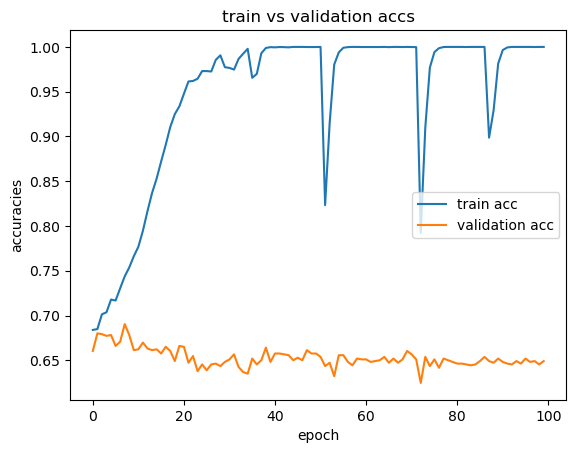

In [108]:
import matplotlib.pyplot as plt 

plt.plot(train_acc, label="train acc")
plt.plot(validation_acc, label="validation acc")

plt.xlabel("epoch")
plt.ylabel("accuracies")
plt.title("train vs validation accs")
plt.legend()
plt.show()

# Hyperparameter Tuning
We will perform grid search on the no. of training epochs, lr, optimizer and batch sizes



Question 2. RNN
(a) Report the final configuration of your best model, namely the number of training epochs,
learning rate, optimizer, batch size.
  - Implement Bayesian search
(b) Report the accuracy score on the test set, as well as the accuracy score on the validation
set for each epoch during training.
(c) RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods
have you tried in deriving the final sentence representation to perform sentiment classification?
Describe all the strategies you have implemented, together with their accuracy scores on the
test set

Embedding with "the" token

In [ ]:
# use "the" as pad 
word2idx["<pad>"]

Others:

Helper function

In [28]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [29]:
embeddings = [word_embeddings[word] for word in word_embeddings.keys()]

embedding_matrix_np = np.array(embeddings)
#embedding_matrix_np = np.vstack((np.zeros((1, 100)), embedding_matrix_np))

embedding_matrix_np.shape


(400000, 100)

In [30]:
# load dataset from huggingface first 
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

with open('result/word2idx.json', "r") as file:
    word2idx = json.load(file)

In [75]:
def train_loop2(train_dataloader, model, loss_fn, optimizer):
    if train_on_gpu:
        model.cuda()
    model.train()
    num_batches = len(train_dataloader)
    size = len(train_dataloader.dataset)
    train_loss, train_correct = 0, 0
    for batch_no, (X_batch, y_batch) in enumerate(train_dataloader):
        y_batch = y_batch.long()
        if train_on_gpu:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
        
        # Forward pass
        pred = model(X_batch)

        print(pred, y_batch)
        loss = loss_fn(pred.squeeze(), y_batch.float())
        train_loss += loss.item() 

        #probabilities = pred.squeeze()
        pred_binary = (pred.squeeze() >= 0.5).long()
        train_correct += (pred_binary == y_batch.long()).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= num_batches 
    train_correct /= size 

    return train_loss, train_correct 
   

def test_loop2(validate_dataloader, model, loss_fn):
    if train_on_gpu:
        model.cuda()
    model.eval()
    num_batches = len(validate_dataloader)
    size = len(validate_dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in validate_dataloader:
            y_batch = y_batch.long()
            if train_on_gpu:
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()

            pred = model(X_batch)
            
            test_loss += loss_fn(pred.squeeze(), y_batch.float()).item()
            
            #probabilities = torch.sigmoid(pred.squeeze())
            pred_binary = (pred.squeeze() >= 0.5).long()
            test_correct += (pred_binary == y_batch.long()).sum().item()

    test_loss /= num_batches
    test_correct /= size
    return test_loss, test_correct

In [50]:
def train_loop(train_dataloader, model, loss_fn, optimizer):
    if train_on_gpu:
        model.cuda()
    model.train()
    num_batches = len(train_dataloader)
    size = len(train_dataloader.dataset)
    train_loss, train_correct = 0, 0
    for batch_no, (X_batch, y_batch) in enumerate(train_dataloader):
        y_batch = y_batch.long()
        if train_on_gpu:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
        
        # Forward pass
        pred = model(X_batch)
        pred = pred.squeeze(1)
        y_val = y_batch
        loss = loss_fn(pred, y_val.float())
        train_loss += loss.item() 
        train_correct += ((pred >= 0.5).long()==y_batch).sum().item() 
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= num_batches 
    train_correct /= size 

    return train_loss, train_correct 
   

def test_loop(validate_dataloader, model, loss_fn):
    if train_on_gpu:
        model.cuda()
    model.eval()
    num_batches = len(validate_dataloader)
    size = len(validate_dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in validate_dataloader:
            y_batch = y_batch.long()
            if train_on_gpu:
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).long()
            test_loss += loss_fn(pred, y_batch.float()).item()
            test_correct += (pred_binary == y_batch).sum().item()

    test_loss /= num_batches
    test_correct /= size
    return test_loss, test_correct

In [68]:
from torch.utils.data import Dataset, DataLoader 

# TODO: change the num_tokens 
class EmbeddingsDataset2(Dataset):
  def __init__(self, X, y, num_tokens_per_sentence=8, word_embeddings=word_embeddings):
    self.num_tokens_per_sentence = num_tokens_per_sentence
    self.word_embeddings = word_embeddings
    self.X = X # train_dataset['text']
    self.y = y # train_dataset['label']
    self.len = len(self.X)

  def __getitem__(self, index):
    # tokenize the sentence 
    tokens = self.tokenize_sentence(self.X[index])
    # convert each token to embeddings 
    sentence_tensor = self.convert_sentence_into_indices(tokens)
    label = torch.tensor(self.y[index], dtype=torch.long)
    return sentence_tensor, label 

  def __len__(self):
    return self.len 

  def tokenize_sentence(self, x): 
    '''
    returns a list containing the embeddings of each token 
    '''
    tokens = nltk.word_tokenize(x.lower())
    return tokens 
  
  def convert_sentence_into_indices(self, tokens):
    indices = []
    num_tokens_used = 0 
    for token in tokens:
      if num_tokens_used == self.num_tokens_per_sentence:
        break # we have enough of tokens from the sentence 
      if token in word2idx:
        indices.append(word2idx[token])
        num_tokens_used += 1 
    # # if not enough tokens in the sentence, use index of ?? 
    if len(indices) < self.num_tokens_per_sentence:
      padding = [0 for _ in range(self.num_tokens_per_sentence - len(indices))]
      indices.extend(padding)
    #print(indices)
    indices = torch.tensor(indices, dtype=torch.long)
    return indices
  

Vanilla RNN with \<pad\>

In [ ]:
# using nn.Embeddings 
import torch
import torch.nn as nn



class VanillaRNNWithEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch=torch.tensor(embedding_matrix_np, dtype=torch.float)):
        super(VanillaRNNWithEmbedding, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Max pooling
        out, _ = torch.max(out, dim=1)
        # Only take the last output for each sequence
        #out = out[:, -1, :]
        # Pass through the fully connected layer
        out = self.fc(out)
        # Apply sigmoid activation (for binary classification)
        #out = self.sigmoid(out)
        
        return out


In [76]:
# using nn.Embeddings 
import torch
import torch.nn as nn



class VanillaRNNWithEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch=torch.tensor(embedding_matrix_np, dtype=torch.float)):
        super(VanillaRNNWithEmbedding, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, hidden = self.rnn(x, h0)
        # Max pooling
        res, _ = torch.max(hidden, dim=1)
        # Only take the last output for each sequence
        #out = out[:, -1, :]
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        out = self.sigmoid(out)
        
        return res


In [77]:
RNN_embeddings_model = VanillaRNNWithEmbedding(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1)
optim = torch.optim.SGD(RNN_embeddings_model.parameters(), lr=0.001, momentum=0.9)


train_dataset_ed2 = EmbeddingsDataset2(train_dataset['text'], train_dataset['label'], num_tokens_per_sentence=25)
validation_dataset_ed2 = EmbeddingsDataset2(validation_dataset['text'], validation_dataset['label'], num_tokens_per_sentence=25)
# test_dataset_ed2 = EmbeddingsDataset(test_dataset['text'], test_dataset['label'])


train_dataloader2 = DataLoader(train_dataset_ed2, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader2 = DataLoader(validation_dataset_ed2, batch_size=BATCH_SIZE, shuffle=True)

criterion = nn.BCEWithLogitsLoss()

validation_acc = [] 
train_acc = []
train_losses, validate_losses = [], []
for i in range(NUM_EPOCHS):
  train_loss, train_correct = train_loop2(train_dataloader2, RNN_embeddings_model, criterion, optim) 
  validate_loss, validate_correct = test_loop2(validation_dataloader2, RNN_embeddings_model, criterion)
  validation_acc.append(validate_correct)
  train_acc.append(train_correct)
  train_losses.append(train_loss)
  validate_losses.append(validate_loss)

  print(f"Epoch {i+1}, Train Loss: {train_loss:.4f}, Validate Loss: {validate_loss:.4f}")
  #if i%10 == 0:
  print(f"Epoch:{i+1} \tValidation Acc:{validate_correct} \tTrain Acc:{train_correct}")
  
  


tensor([[-0.1885],
        [-0.1809]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')


ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([2]))

In [60]:
RNN_embeddings_model = VanillaRNNWithEmbedding(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1)
optim = torch.optim.Adam(RNN_embeddings_model.parameters(), lr=0.0001)


train_dataset_ed2 = EmbeddingsDataset2(train_dataset['text'], train_dataset['label'], num_tokens_per_sentence=25)
validation_dataset_ed2 = EmbeddingsDataset2(validation_dataset['text'], validation_dataset['label'], num_tokens_per_sentence=25)
# test_dataset_ed2 = EmbeddingsDataset(test_dataset['text'], test_dataset['label'])


train_dataloader2 = DataLoader(train_dataset_ed2, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader2 = DataLoader(validation_dataset_ed2, batch_size=BATCH_SIZE, shuffle=True)

criterion = nn.BCEWithLogitsLoss()

validation_acc = [] 
train_acc = []
train_losses, validate_losses = [], []
for i in range(NUM_EPOCHS):
  train_loss, train_correct = train_loop2(train_dataloader2, RNN_embeddings_model, criterion, optim) 
  validate_loss, validate_correct = test_loop2(validation_dataloader2, RNN_embeddings_model, criterion)
  validation_acc.append(validate_correct)
  train_acc.append(train_correct)
  train_losses.append(train_loss)
  validate_losses.append(validate_loss)

  print(f"Epoch {i+1}, Train Loss: {train_loss:.4f}, Validate Loss: {validate_loss:.4f}")
  #if i%10 == 0:
  print(f"Epoch:{i+1} \tValidation Acc:{validate_correct} \tTrain Acc:{train_correct}")
  
  


Epoch 1, Train Loss: 0.6951, Validate Loss: 0.6895
Epoch:1 	Validation Acc:0.5619136960600375 	Train Acc:0.5073856975381008
Epoch 2, Train Loss: 0.6906, Validate Loss: 0.6854
Epoch:2 	Validation Acc:0.5412757973733584 	Train Acc:0.5262602579132474
Epoch 3, Train Loss: 0.6844, Validate Loss: 0.6773
Epoch:3 	Validation Acc:0.5881801125703565 	Train Acc:0.5610785463071513
Epoch 4, Train Loss: 0.6770, Validate Loss: 0.6703
Epoch:4 	Validation Acc:0.5956848030018762 	Train Acc:0.5722157092614303
Epoch 5, Train Loss: 0.6722, Validate Loss: 0.6682
Epoch:5 	Validation Acc:0.6031894934333959 	Train Acc:0.5835873388042204
Epoch 6, Train Loss: 0.6673, Validate Loss: 0.6689
Epoch:6 	Validation Acc:0.5975609756097561 	Train Acc:0.5951934349355217
Epoch 7, Train Loss: 0.6653, Validate Loss: 0.6681
Epoch:7 	Validation Acc:0.5928705440900562 	Train Acc:0.5984759671746777
Epoch 8, Train Loss: 0.6623, Validate Loss: 0.6761
Epoch:8 	Validation Acc:0.5675422138836773 	Train Acc:0.6026963657678781
Epoch 9,

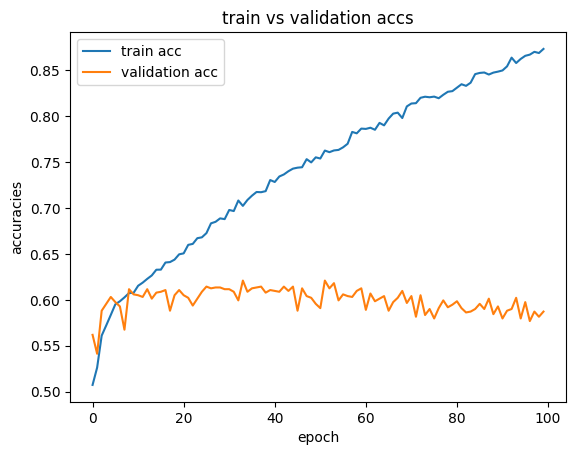

In [61]:
import matplotlib.pyplot as plt 

plt.plot(train_acc, label="train acc")
plt.plot(validation_acc, label="validation acc")

plt.xlabel("epoch")
plt.ylabel("accuracies")
plt.title("train vs validation accs")
plt.legend()
plt.show()

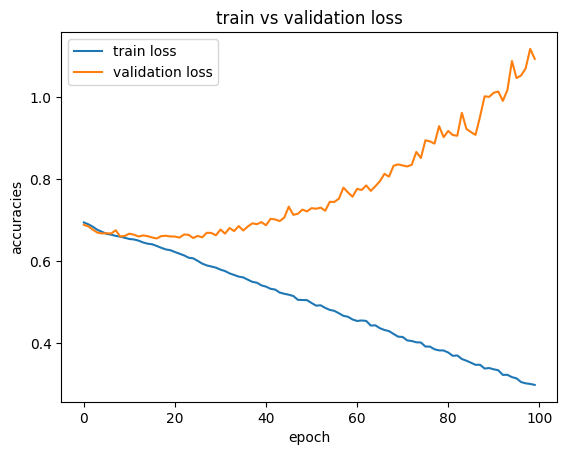

In [62]:
import matplotlib.pyplot as plt 

plt.plot(train_losses, label="train loss")
plt.plot(validate_losses, label="validation loss")

plt.xlabel("epoch")
plt.ylabel("accuracies")
plt.title("train vs validation loss")
plt.legend()
plt.show()

Bayesian search!

In [135]:
def black_box(learning_rate, epoch, batch_size, num_layers): # A list of hyperparameters to optimize
    validation_acc = [] 
    train_acc = []
    train_correct, validate_correct = 0, 0

    epoch = int(epoch)
    batch_size = int(batch_size)
    num_layers = int(num_layers)

    criterion = nn.BCELoss()

    RNN_embeddings_model = VanillaRNNWithEmbedding(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=num_layers, num_classes=1)
    optim = torch.optim.Adam(RNN_embeddings_model.parameters(), lr=learning_rate)

    train_dataset_ed2 = EmbeddingsDataset2(train_dataset['text'], train_dataset['label'])
    validation_dataset_ed2 = EmbeddingsDataset2(validation_dataset['text'], validation_dataset['label'])
    # test_dataset_ed2 = EmbeddingsDataset(test_dataset['text'], test_dataset['label'])

    train_dataloader2 = DataLoader(train_dataset_ed2, batch_size=batch_size, shuffle=True)
    validation_dataloader2 = DataLoader(validation_dataset_ed2, batch_size=batch_size, shuffle=True)
    for _ in range(epoch):
        train_loss, train_correct = train_loop(train_dataloader2, RNN_embeddings_model, criterion, optim) 
        validate_loss, validate_correct = test_loop(validation_dataloader2, RNN_embeddings_model, criterion)
        #validation_acc.append(validate_correct)
        #train_acc.append(train_correct)
    return validate_correct

In [ ]:
from bayes_opt import BayesianOptimization
optimizer = BayesianOptimization(
    f=black_box,
    pbounds={"learning_rate": (0.0001, 0.01), "epoch": (1, 60), "batch_size": (5, 64), "num_layers": (1, 8)},
    random_state=1,
    verbose=2
)


In [20]:
optimizer.maximize(init_points=5, n_iter=30)

|   iter    |  target   | batch_... |   epoch   | learni... | num_la... |
-------------------------------------------------------------------------


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 1         | 0.5385    | 29.6      | 72.31     | 0.0001114 | 3.116     |
| 2         | 0.5       | 13.66     | 10.14     | 0.01871   | 3.419     |
| 3         | 0.5       | 28.41     | 54.34     | 0.04198   | 5.797     |
| 4         | 0.5       | 17.06     | 87.93     | 0.002836  | 5.693     |
| 5         | 0.5       | 29.62     | 56.31     | 0.01412   | 2.387     |
| 6         | 0.5       | 52.24     | 96.86     | 0.03141   | 5.846     |
| 7         | 0.4944    | 56.71     | 89.57     | 0.008596  | 1.273     |
| 8         | 0.5       | 15.02     | 87.94     | 0.009925  | 3.948     |
| 9         | 0.5       | 61.52     | 53.78     | 0.06922   | 3.209     |
| 10        | 0.5394    | 45.5      | 83.63     | 0.001927  | 6.251     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 11        | 0.5009    | 38.32     | 78.24     | 0.03072   | 5.91      |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 12        | 0.5       | 48.27     | 82.71     | 0.01068   | 7.913     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 13        | 0.5       | 46.25     | 83.35     | 0.07759   | 7.262     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 14        | 0.5       | 6.251     | 80.98     | 0.09649   | 5.915     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 15        | 0.5       | 26.5      | 3.217     | 0.01533   | 7.801     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 16        | 0.5       | 29.39     | 71.92     | 0.07659   | 3.316     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 17        | 0.5       | 62.89     | 27.77     | 0.0809    | 4.126     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 18        | 0.5       | 24.17     | 63.94     | 0.04011   | 6.261     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 19        | 0.5       | 23.05     | 67.99     | 0.05518   | 3.211     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 20        | 0.5       | 28.43     | 20.22     | 0.00538   | 3.415     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 21        | 0.4991    | 5.558     | 55.47     | 0.01628   | 4.345     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 22        | 0.5       | 24.61     | 48.99     | 0.04174   | 6.746     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 23        | 0.5       | 18.81     | 45.25     | 0.05506   | 7.644     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 24        | 0.5       | 11.95     | 55.5      | 0.0492    | 2.022     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 25        | 0.5169    | 20.5      | 3.162     | 0.01683   | 5.491     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 26        | 0.5       | 16.57     | 40.64     | 0.05158   | 1.491     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 27        | 0.5       | 15.67     | 27.91     | 0.08037   | 5.536     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 28        | 0.5       | 12.89     | 51.28     | 0.08892   | 4.97      |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 29        | 0.5       | 13.95     | 21.22     | 0.06728   | 7.124     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 30        | 0.5638    | 53.26     | 17.19     | 0.001602  | 2.127     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 31        | 0.5       | 63.17     | 71.12     | 0.05829   | 6.223     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 32        | 0.5       | 58.04     | 45.77     | 0.03998   | 3.181     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 33        | 0.5       | 46.4      | 39.04     | 0.02691   | 4.424     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 34        | 0.5       | 63.66     | 26.33     | 0.0619    | 3.589     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 35        | 0.5       | 55.21     | 78.51     | 0.09023   | 1.654     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 36        | 0.5028    | 28.28     | 65.22     | 0.01577   | 3.921     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 37        | 0.5       | 36.82     | 39.82     | 0.09373   | 3.952     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 38        | 0.4991    | 33.82     | 7.355     | 0.03303   | 5.481     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 39        | 0.5056    | 28.93     | 2.383     | 0.04087   | 6.515     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 40        | 0.5       | 43.65     | 22.56     | 0.0703    | 7.349     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 41        | 0.5       | 22.78     | 63.6      | 0.0893    | 4.529     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 42        | 0.4991    | 48.67     | 98.4      | 0.01612   | 6.188     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 43        | 0.5       | 26.22     | 51.19     | 0.07251   | 4.647     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 44        | 0.5       | 33.65     | 69.15     | 0.0648    | 6.607     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 45        | 0.5       | 59.91     | 91.34     | 0.07552   | 5.825     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 46        | 0.5       | 28.21     | 94.5      | 0.07652   | 6.504     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 47        | 0.5       | 25.66     | 94.35     | 0.038     | 3.026     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 48        | 0.5       | 30.48     | 68.21     | 0.09317   | 5.729     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 49        | 0.5       | 43.05     | 13.4      | 0.06798   | 2.798     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 50        | 0.5       | 29.86     | 42.39     | 0.08251   | 3.506     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 51        | 0.5       | 61.73     | 68.52     | 0.05952   | 5.858     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 52        | 0.4962    | 63.43     | 64.76     | 0.008872  | 1.494     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 53        | 0.5       | 30.29     | 18.37     | 0.04175   | 6.959     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 54        | 0.5       | 45.66     | 12.67     | 0.0544    | 5.896     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 55        | 0.5       | 27.43     | 84.99     | 0.04115   | 3.61      |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 56        | 0.5       | 50.99     | 90.4      | 0.05129   | 3.067     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 57        | 0.5       | 44.15     | 46.33     | 0.03891   | 1.568     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 58        | 0.4991    | 59.4      | 31.25     | 0.0541    | 1.812     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 59        | 0.5009    | 21.91     | 11.28     | 0.08537   | 1.988     |


C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_101968\4173132243.py:44: UserWarning: To copy

| 60        | 0.5       | 47.47     | 29.42     | 0.02467   | 2.23      |


In [21]:
print(optimizer.max)

{'target': np.float64(0.5637898686679175), 'params': {'batch_size': np.float64(53.26447499168856), 'epoch': np.float64(17.18914449561826), 'learning_rate': np.float64(0.0016018184281454636), 'num_layers': np.float64(2.1269209601583134)}}


In [23]:
optimizer.set_bounds(new_bounds={"learning_rate": (0.0001, 0.01), "epoch": (1, 60), "batch_size": (5, 64), "num_layers": (1, 8)})

In [25]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path="./logs.log")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [26]:
optimizer.maximize(
    init_points=0,
    n_iter=10,
)

|   iter    |  target   | batch_... |   epoch   | learni... | num_la... |
-------------------------------------------------------------------------
| 62        | 0.5       | 33.12     | 49.11     | 0.006336  | 7.38      |
| 63        | 0.5       | 47.49     | 34.79     | 0.006623  | 7.939     |
| 64        | 0.5       | 14.38     | 29.23     | 0.005116  | 1.848     |
| 65        | 0.5028    | 62.63     | 32.79     | 0.009846  | 6.543     |
| 66        | 0.5       | 37.97     | 12.79     | 0.008052  | 1.569     |
| 67        | 0.485     | 52.05     | 11.81     | 0.002247  | 7.624     |
| 68        | 0.5       | 15.72     | 53.75     | 0.005095  | 7.904     |
| 69        | 0.4756    | 45.07     | 49.91     | 0.003345  | 3.658     |
| 70        | 0.4841    | 52.16     | 17.05     | 0.007017  | 4.107     |
| 71        | 0.5       | 28.8      | 59.24     | 0.006845  | 7.359     |


In [27]:
optimizer.maximize(
    init_points=0,
    n_iter=20,
)

|   iter    |  target   | batch_... |   epoch   | learni... | num_la... |
-------------------------------------------------------------------------
| 72        | 0.5272    | 42.96     | 37.04     | 0.008657  | 2.45      |
| 73        | 0.5047    | 36.86     | 19.95     | 0.008388  | 7.927     |
| 74        | 0.4934    | 52.18     | 23.63     | 0.007858  | 5.999     |
| 75        | 0.5       | 63.94     | 35.5      | 0.004804  | 7.199     |
| 76        | 0.5516    | 63.59     | 16.72     | 0.0005364 | 4.827     |
| 77        | 0.5       | 38.62     | 3.055     | 0.008401  | 4.782     |
| 78        | 0.5       | 12.55     | 9.951     | 0.006469  | 2.334     |
| 79        | 0.5       | 61.25     | 46.2      | 0.009997  | 3.355     |
| 80        | 0.5066    | 7.714     | 15.33     | 0.003516  | 1.604     |
| 81        | 0.4878    | 16.89     | 14.01     | 0.008163  | 6.2       |
| 82        | 0.4981    | 36.11     | 48.68     | 0.007921  | 5.503     |
| 83        | 0.5       | 58.9      | 

In [28]:
print(optimizer.max)

{'target': np.float64(0.5637898686679175), 'params': {'batch_size': np.float64(53.26447499168856), 'epoch': np.float64(17.18914449561826), 'learning_rate': np.float64(0.0016018184281454636), 'num_layers': np.float64(2.1269209601583134)}}


RNN with dropout

In [ ]:
# using nn.Embeddings 
import torch
import torch.nn as nn

class VanillaRNNWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch=torch.tensor(embedding_matrix_np, dtype=torch.float)):
        super(VanillaRNNWithDropout, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=0)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Only take the last output for each sequence
        out = out[:, -1, :]
        # Dropout
        out = self.dropout(out)
        # Pass through the fully connected layer
        out = self.fc(out)
        # Apply sigmoid activation (for binary classification)
        out = self.sigmoid(out)
        
        return out

criterion = nn.BCELoss()


In [ ]:
def black_box(learning_rate, epoch, batch_size, num_layers): # A list of hyperparameters to optimize
    validation_acc = [] 
    train_acc = []
    train_correct, validate_correct = 0, 0

    epoch = int(epoch)
    batch_size = int(batch_size)
    num_layers = int(num_layers)

    criterion = nn.BCELoss()

    RNN_embeddings_model = VanillaRNNWithDropout(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=num_layers, num_classes=1)
    optim = torch.optim.Adam(RNN_embeddings_model.parameters(), lr=learning_rate)

    train_dataset_ed2 = EmbeddingsDataset2(train_dataset['text'], train_dataset['label'])
    validation_dataset_ed2 = EmbeddingsDataset2(validation_dataset['text'], validation_dataset['label'])
    # test_dataset_ed2 = EmbeddingsDataset(test_dataset['text'], test_dataset['label'])

    train_dataloader2 = DataLoader(train_dataset_ed2, batch_size=batch_size, shuffle=True)
    validation_dataloader2 = DataLoader(validation_dataset_ed2, batch_size=batch_size, shuffle=True)
    for _ in range(epoch):
        train_loss, train_correct = train_loop(train_dataloader2, RNN_embeddings_model, criterion, optim) 
        validate_loss, validate_correct = test_loop(validation_dataloader2, RNN_embeddings_model, criterion)
        #validation_acc.append(validate_correct)
        #train_acc.append(train_correct)
    return validate_correct

In [ ]:
from bayes_opt import BayesianOptimization
optimizer = BayesianOptimization(
    f=black_box,
    pbounds={"learning_rate": (0.0001, 0.01), "epoch": (1, 60), "batch_size": (5, 64), "num_layers": (1, 8)},
    random_state=1,
    verbose=2
)
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path="./logs_dropout.log")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [49]:
optimizer.probe(
    params={"learning_rate": 0.0016, "epoch": 17, "batch_size": 53, "num_layers": 2},
    lazy = True
)

In [50]:
optimizer.maximize(init_points=2, n_iter=60)

test 0.5694183864915572
test 0.5450281425891182
test 0.5112570356472795
test 0.5769230769230769
test 0.5
test 0.5
test 0.5891181988742964
test 0.5150093808630394
test 0.5
test 0.4896810506566604
test 0.5234521575984991
test 0.549718574108818
test 0.5478424015009381
test 0.5
test 0.5046904315196998
test 0.5
test 0.49343339587242024
test 0.5422138836772983
test 0.5075046904315197
test 0.5
test 0.5
test 0.5787992495309568
test 0.5647279549718575
test 0.5140712945590994
test 0.5
test 0.5
test 0.49343339587242024
test 0.5
test 0.5797373358348968
test 0.5
test 0.4906191369606004
test 0.5
test 0.5103189493433395
test 0.5121951219512195
test 0.5
test 0.5
test 0.5553470919324578
test 0.5
test 0.50093808630394
test 0.5
test 0.5037523452157598
test 0.50093808630394
test 0.5
test 0.5234521575984991
test 0.5478424015009381
test 0.5
test 0.5
test 0.49906191369606
test 0.50187617260788
test 0.5309568480300187
test 0.49624765478424016
test 0.5093808630393997
test 0.5562851782363978
test 0.568480300187

In [51]:
optimizer.max

{'target': np.float64(0.5891181988742964),
 'params': {'batch_size': np.float64(55.01782564205619),
  'epoch': np.float64(17.216924152295988),
  'learning_rate': np.float64(0.0029747238556237883),
  'num_layers': np.float64(1.5953275626132635)}}

In [52]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': np.float64(0.5694183864915572), 'params': {'batch_size': np.float64(53.0), 'epoch': np.float64(17.0), 'learning_rate': np.float64(0.0016), 'num_layers': np.float64(2.0)}}
Iteration 1: 
	{'target': np.float64(0.5450281425891182), 'params': {'batch_size': np.float64(29.604298277451868), 'epoch': np.float64(43.49914511308733), 'learning_rate': np.float64(0.00010113231069171439), 'num_layers': np.float64(3.1163280084228786)}}
Iteration 2: 
	{'target': np.float64(0.5112570356472795), 'params': {'batch_size': np.float64(13.658597558209669), 'epoch': np.float64(6.44797709135907), 'learning_rate': np.float64(0.0019439760926389421), 'num_layers': np.float64(3.418925089301334)}}
Iteration 3: 
	{'target': np.float64(0.5769230769230769), 'params': {'batch_size': np.float64(53.865065176555866), 'epoch': np.float64(16.021065076802277), 'learning_rate': np.float64(0.0022729686141519097), 'num_layers': np.float64(2.322985558014845)}}
Iteration 4: 
	{'target': np.float64(0.5),

RNN with dropout & more token

In [ ]:
def black_box_with_token(learning_rate, epoch, batch_size, num_layers, num_tokens): # A list of hyperparameters to optimize
    validation_acc = [] 
    train_acc = []
    train_correct, validate_correct = 0, 0

    # make sure the parameters are integers, since bayesian optimization return float
    # refer to: https://colab.research.google.com/github/bayesian-optimization/BayesianOptimization/blob/master/examples/advanced-tour.ipynb#scrollTo=QWqhKqCnvZmn
    epoch = int(epoch)
    batch_size = int(batch_size)
    num_layers = int(num_layers)
    num_tokens = int(num_tokens)

    criterion = nn.BCELoss()

    RNN_embeddings_model = VanillaRNNWithDropout(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=num_layers, num_classes=1)
    optim = torch.optim.Adam(RNN_embeddings_model.parameters(), lr=learning_rate)

    train_dataset_ed2 = EmbeddingsDataset2(train_dataset['text'], train_dataset['label'], num_tokens_per_sentence=num_tokens)
    validation_dataset_ed2 = EmbeddingsDataset2(validation_dataset['text'], validation_dataset['label'], num_tokens_per_sentence=num_tokens)
    # test_dataset_ed2 = EmbeddingsDataset(test_dataset['text'], test_dataset['label'])

    train_dataloader2 = DataLoader(train_dataset_ed2, batch_size=batch_size, shuffle=True)
    validation_dataloader2 = DataLoader(validation_dataset_ed2, batch_size=batch_size, shuffle=True)
    for _ in range(epoch):
        train_loss, train_correct = train_loop(train_dataloader2, RNN_embeddings_model, criterion, optim) 
        validate_loss, validate_correct = test_loop(validation_dataloader2, RNN_embeddings_model, criterion)
        #validation_acc.append(validate_correct)
        #train_acc.append(train_correct)
    return validate_correct

In [ ]:
from bayes_opt import BayesianOptimization
optimizer = BayesianOptimization(
    f=black_box_with_token,
    pbounds={"learning_rate": (0.0001, 0.01), "epoch": (1, 60), "batch_size": (5, 64), "num_layers": (1, 8), "num_tokens": (16, 26)},
    random_state=1,
    verbose=2
)
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path="./logs_dropout_token.log")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [55]:
optimizer.probe(
    params={"learning_rate": 0.0016, "epoch": 17, "batch_size": 53, "num_layers": 2, "num_tokens": 20},
    lazy = True
)

In [56]:
optimizer.maximize(init_points=5, n_iter=100)

In [57]:
optimizer.max

{'target': np.float64(0.5600375234521576),
 'params': {'batch_size': np.float64(63.02362224905339),
  'epoch': np.float64(6.191456753164534),
  'learning_rate': np.float64(0.0006502875347645216),
  'num_layers': np.float64(3.530788193240186),
  'num_tokens': np.float64(24.5764309091781)}}

In [58]:
sorted(optimizer.res, key=lambda x: x['target'])[-5:]

[{'target': np.float64(0.5440900562851783),
  'params': {'batch_size': np.float64(29.604298277451868),
   'epoch': np.float64(43.49914511308733),
   'learning_rate': np.float64(0.00010113231069171439),
   'num_layers': np.float64(3.1163280084228786),
   'num_tokens': np.float64(16.46755890817113)}},
 {'target': np.float64(0.5487804878048781),
  'params': {'batch_size': np.float64(17.895131677247917),
   'epoch': np.float64(17.931185536260774),
   'learning_rate': np.float64(0.00019660957174913565),
   'num_layers': np.float64(3.2833213709768443),
   'num_tokens': np.float64(18.976001443018905)}},
 {'target': np.float64(0.551594746716698),
  'params': {'batch_size': np.float64(62.28906779058867),
   'epoch': np.float64(19.139926846575833),
   'learning_rate': np.float64(0.00010016845106199955),
   'num_layers': np.float64(7.370817526373162),
   'num_tokens': np.float64(19.92278535746045)}},
 {'target': np.float64(0.5525328330206379),
  'params': {'batch_size': np.float64(27.691288457159

Dropout + learnable hidden state

In [22]:
# using nn.Embeddings 
import torch
import torch.nn as nn

class DropoutInitialRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch=torch.tensor(embedding_matrix_np, dtype=torch.float)):
        super(DropoutInitialRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=0)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)
        self.h0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_size, dtype=torch.float))
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x)
        h0 = self.h0.expand(-1, x.size(0), -1).contiguous().to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Only take the last output for each sequence
        out = out[:, -1, :]
        # Dropout
        out = self.dropout(out)
        # Pass through the fully connected layer
        out = self.fc(out)
        # Apply sigmoid activation (for binary classification)
        out = self.sigmoid(out)
        
        return out

criterion = nn.BCELoss()


In [23]:
def black_box_with_token(learning_rate, epoch, batch_size, num_layers, num_tokens): # A list of hyperparameters to optimize
    validation_acc = [] 
    train_acc = []
    train_correct, validate_correct = 0, 0

    # make sure the parameters are integers, since bayesian optimization return float
    # refer to: https://colab.research.google.com/github/bayesian-optimization/BayesianOptimization/blob/master/examples/advanced-tour.ipynb#scrollTo=QWqhKqCnvZmn
    epoch = int(epoch)
    batch_size = int(batch_size)
    num_layers = int(num_layers)
    num_tokens = int(num_tokens)

    criterion = nn.BCELoss()

    RNN_embeddings_model = DropoutInitialRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=num_layers, num_classes=1)
    optim = torch.optim.Adam(RNN_embeddings_model.parameters(), lr=learning_rate)

    train_dataset_ed2 = EmbeddingsDataset2(train_dataset['text'], train_dataset['label'], num_tokens_per_sentence=num_tokens)
    validation_dataset_ed2 = EmbeddingsDataset2(validation_dataset['text'], validation_dataset['label'], num_tokens_per_sentence=num_tokens)
    # test_dataset_ed2 = EmbeddingsDataset(test_dataset['text'], test_dataset['label'])

    train_dataloader2 = DataLoader(train_dataset_ed2, batch_size=batch_size, shuffle=True)
    validation_dataloader2 = DataLoader(validation_dataset_ed2, batch_size=batch_size, shuffle=True)
    for _ in range(epoch):
        train_loss, train_correct = train_loop(train_dataloader2, RNN_embeddings_model, criterion, optim) 
        validate_loss, validate_correct = test_loop(validation_dataloader2, RNN_embeddings_model, criterion)
        #validation_acc.append(validate_correct)
        #train_acc.append(train_correct)
    return validate_correct

In [27]:
from bayes_opt import BayesianOptimization
optimizer_dropout_initial = BayesianOptimization(
    f=black_box_with_token,
    pbounds={"learning_rate": (0.0001, 0.01), "epoch": (5, 60), "batch_size": (10, 64), "num_layers": (1, 4), "num_tokens": (16, 26)},
    random_state=1,
    verbose=2
)
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path="./logs_dropout_token_initial.log")
optimizer_dropout_initial.subscribe(Events.OPTIMIZATION_STEP, logger)

In [28]:
optimizer_dropout_initial.probe(
    params={"learning_rate": 0.00019, "epoch": 17, "batch_size": 17, "num_layers": 3, "num_tokens": 18},
    lazy = True
)

In [ ]:
optimizer_dropout_initial.maximize(init_points=4, n_iter=100)

In [ ]:
sorted(optimizer_dropout_initial.res, key=lambda x: x['target'])[-5:]

Variable Dropout

In [125]:
# using nn.Embeddings 
import torch
import torch.nn as nn

class VarDropoutInitialRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch=torch.tensor(embedding_matrix_np, dtype=torch.float), drop_out = 0.3):
        super(VarDropoutInitialRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=0)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(drop_out)
        self.h0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_size, dtype=torch.float))
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x)
        h0 = self.h0.expand(-1, x.size(0), -1).contiguous().to(x.device)
        # Pass the embeddings through the RNN layer
        out, hidden = self.rnn(x, h0)
        # Only take the last output for each sequence
        res = hidden[-1]
        # Dropout
        res = self.dropout(res)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)
        
        return res

criterion = nn.BCELoss()


In [126]:
from torch.utils.data import Dataset, DataLoader 

# TODO: change the num_tokens 
class EmbeddingsDataset3(Dataset):
  def __init__(self, X, y, num_tokens_per_sentence=8, word_embeddings=word_embeddings):
    self.num_tokens_per_sentence = num_tokens_per_sentence
    self.word_embeddings = word_embeddings

    sentence_lengths = [len(nltk.word_tokenize(x)) for x in X]
    sorted_indices = sorted(range(len(X)), key=lambda i: sentence_lengths[i])
    
    self.X = [X[i] for i in sorted_indices] # train_dataset['text']
    self.y = [y[i] for i in sorted_indices] # train_dataset['label']

    self.len = len(self.X)

  def __getitem__(self, index):
    # tokenize the sentence 
    tokens = self.tokenize_sentence(self.X[index])
    # convert each token to embeddings 
    sentence_tensor = self.convert_sentence_into_indices(tokens)
    label = torch.tensor(self.y[index], dtype=torch.float)
    return sentence_tensor, label 

  def __len__(self):
    return self.len 

  def tokenize_sentence(self, x): 
    '''
    returns a list containing the embeddings of each token 
    '''
    tokens = nltk.word_tokenize(x)
    return tokens 
  
  def convert_sentence_into_indices(self, tokens):
    indices = []
    num_tokens_used = 0 
    for token in tokens:
      if num_tokens_used == self.num_tokens_per_sentence:
        break # we have enough of tokens from the sentence 
      if token in word2idx:
        indices.append(word2idx[token])
        num_tokens_used += 1 
    # # if not enough tokens in the sentence, use index of ?? 
    if len(indices) < self.num_tokens_per_sentence:
      padding = [0 for _ in range(self.num_tokens_per_sentence - len(indices))]
      indices.extend(padding)

    indices = torch.tensor(indices, dtype=torch.long)
    return indices
  

In [127]:
train_dataset_ed3 = EmbeddingsDataset3(train_dataset['text'], train_dataset['label'])
validation_dataset_ed3 = EmbeddingsDataset3(validation_dataset['text'], validation_dataset['label'])
# test_dataset_ed2 = EmbeddingsDataset(test_dataset['text'], test_dataset['label'])


train_dataloader3 = DataLoader(train_dataset_ed3, batch_size=BATCH_SIZE, shuffle=False)
validation_dataloader3 = DataLoader(validation_dataset_ed3, batch_size=BATCH_SIZE, shuffle=False)

In [128]:
def black_box_with_token(learning_rate, epoch, batch_size, num_layers, num_tokens, drop_out): # A list of hyperparameters to optimize
    validation_acc = [] 
    train_acc = []
    train_correct, validate_correct = 0, 0

    # make sure the parameters are integers, since bayesian optimization return float
    # refer to: https://colab.research.google.com/github/bayesian-optimization/BayesianOptimization/blob/master/examples/advanced-tour.ipynb#scrollTo=QWqhKqCnvZmn
    epoch = int(epoch)
    batch_size = int(batch_size)
    num_layers = int(num_layers)
    num_tokens = int(num_tokens)

    criterion = nn.BCELoss()

    RNN_embeddings_model = VarDropoutInitialRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=num_layers, num_classes=1, drop_out=drop_out)
    optim = torch.optim.Adam(RNN_embeddings_model.parameters(), lr=learning_rate)

    train_dataset_ed = EmbeddingsDataset3(train_dataset['text'], train_dataset['label'], num_tokens_per_sentence=num_tokens)
    validation_dataset_ed = EmbeddingsDataset3(validation_dataset['text'], validation_dataset['label'], num_tokens_per_sentence=num_tokens)
    # test_dataset_ed2 = EmbeddingsDataset(test_dataset['text'], test_dataset['label'])

    train_dataloader = DataLoader(train_dataset_ed, batch_size=batch_size, shuffle=False)
    validation_dataloader = DataLoader(validation_dataset_ed, batch_size=batch_size, shuffle=False)
    for _ in range(epoch):
        train_loss, train_correct = train_loop(train_dataloader, RNN_embeddings_model, criterion, optim) 
        validate_loss, validate_correct = test_loop(validation_dataloader, RNN_embeddings_model, criterion)
        #validation_acc.append(validate_correct)
        #train_acc.append(train_correct)
    return validate_correct

In [129]:
from bayes_opt import BayesianOptimization
optimizer_dropout_initial = BayesianOptimization(
    f=black_box_with_token,
    pbounds={"learning_rate": (0.0001, 0.01), "epoch": (5, 60), "batch_size": (10, 64), "num_layers": (1, 4), "num_tokens": (16, 26), "drop_out": (0.1, 0.5)},
    random_state=1,
    verbose=2
)
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path="./logs_var_dropout_token_initial_sorted.log")
optimizer_dropout_initial.subscribe(Events.OPTIMIZATION_STEP, logger)

In [130]:
optimizer_dropout_initial.maximize(init_points=10, n_iter=100)

KeyboardInterrupt: 